<a href="https://colab.research.google.com/github/facahto/Kaggle-competition-practice/blob/main/forecasting-store_sales/Stores_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd, numpy as np
import torch
import datetime as dt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM


label_encoder = preprocessing.LabelEncoder()

Data

In [2]:
# Holiday Event
h_e = pd.read_csv('holidays_events.csv')
display(h_e.head(3))
print()
print(h_e.info())
#display(h_e[h_e.duplicated(keep=False)]) ----- NO DUPLICATED DATA

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None


In [3]:
# Oil
oil = pd.read_csv('oil.csv')
oil['dcoilwtico'].fillna(float(oil['dcoilwtico'].mean()), inplace=True)
display(oil.head(3))
print()
print(oil.info())
#display(oil[oil.duplicated(keep=False)])  ----- NO DUPLICATED DATA

,date,dcoilwtico
0,2013-01-01,67.714366
1,2013-01-02,93.140000
2,2013-01-03,92.970000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1218 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None


In [4]:
# Stores
stores = pd.read_csv('stores.csv')
display(stores.head(3))
print()
print(stores.info())
#display(stores[stores.duplicated(keep=False)])  ----- NO DUPLICATED DATA

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None


In [5]:
# Transactions
ts = pd.read_csv('transactions.csv')
display(ts)
print()
print(ts.info())
#display(ts[ts.duplicated(keep=False)])  ----- NO DUPLICATED DATA

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB
None


In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
display(train.head())

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [7]:
# Preprocessing train data
train['family']= label_encoder.fit_transform(train['family'])
test['family']= label_encoder.fit_transform(test['family'])

In [8]:
train = pd.merge(train, ts, how="left", on=["date", "store_nbr"])
train = pd.merge(train, oil, how="left", on="date")
train

,id,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico
0,0,2013-01-01,1,0,0.000,0,NaN,67.714366
1,1,2013-01-01,1,1,0.000,0,NaN,67.714366
2,2,2013-01-01,1,2,0.000,0,NaN,67.714366
3,3,2013-01-01,1,3,0.000,0,NaN,67.714366
4,4,2013-01-01,1,4,0.000,0,NaN,67.714366
...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,28,438.133,0,2155.0,47.570000
3000884,3000884,2017-08-15,9,29,154.553,1,2155.0,47.570000
3000885,3000885,2017-08-15,9,30,2419.729,148,2155.0,47.570000
3000886,3000886,2017-08-15,9,31,121.000,8,2155.0,47.570000


In [9]:
nan     = train.isna().sum()
nan_row = train[train.isna().any(axis=1)]
print("Jumlah nilai NaN:", nan)

Jumlah nilai NaN: id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
transactions    245784
dcoilwtico      857142
dtype: int64


In [10]:
train['dcoilwtico'].fillna(float(train['dcoilwtico'].mean()), inplace=True)
#train['transactions'].fillna(float(train['transactions'].mean()), inplace=True)
display(train)

,id,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico
0,0,2013-01-01,1,0,0.000,0,NaN,67.714366
1,1,2013-01-01,1,1,0.000,0,NaN,67.714366
2,2,2013-01-01,1,2,0.000,0,NaN,67.714366
3,3,2013-01-01,1,3,0.000,0,NaN,67.714366
4,4,2013-01-01,1,4,0.000,0,NaN,67.714366
...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,28,438.133,0,2155.0,47.570000
3000884,3000884,2017-08-15,9,29,154.553,1,2155.0,47.570000
3000885,3000885,2017-08-15,9,30,2419.729,148,2155.0,47.570000
3000886,3000886,2017-08-15,9,31,121.000,8,2155.0,47.570000


In [11]:
display(test)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,0,0
1,3000889,2017-08-16,1,1,0
2,3000890,2017-08-16,1,2,2
3,3000891,2017-08-16,1,3,20
4,3000892,2017-08-16,1,4,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,28,1
28508,3029396,2017-08-31,9,29,0
28509,3029397,2017-08-31,9,30,1
28510,3029398,2017-08-31,9,31,9


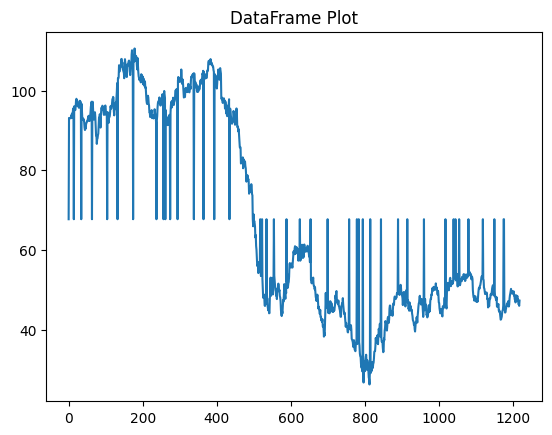

In [12]:
## predict oil price for test dataframe
plot   = oil['dcoilwtico'].plot(title="DataFrame Plot")
start  = dt.datetime(2012,1,1)
end    = dt.datetime(2012,1,1)

scaler = MinMaxScaler(feature_range=(0,1))
